In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

## DC Input - Voltage Distribution - Closed Circuit

In [108]:
def shift_and_append(dfs_dict,col=1):
    for name, df in dfs_dict.items():
        col1 = df.pop(f"{col}")
        df.columns = range(df.shape[1])
        df[len(df.columns)] = col1
    return dfs_dict

def drop_columns(dfs_dict):
    for name, df in dfs_dict.items():
        df = df.drop(columns=[1,2,3,4,5,6])
        df.columns = range(df.shape[1])
        dfs_dict[name] = df
    return dfs_dict

folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_disorder/"
folder_ref  = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_volt/"
U_0         = 0.02
N_nets      = 10
N_p         = 9
N_particles = N_p*N_p
N_voltages  = 50000
t_vals      = np.arange(N_voltages-1)*1e-10*1e9

pot     = {i : pd.read_csv(f"{folder}mean_state_custom_network_{i}.csv").round(5) for i in range(N_nets)}
pot_ref = {0 : pd.read_csv(f"{folder_ref}mean_state_Nx=9_Ny=9_Ne=8_0.020.csv")}
pot     = shift_and_append(pot, col=7)
pot     = drop_columns(pot)
pot_ref = shift_and_append(pot_ref, col=7)
pot_ref = drop_columns(pot_ref)[0]
pot_eq  = pd.DataFrame([pot[i].iloc[48000:,:].mean().values / U_0 for i in range(N_nets)]).T.round(2)

rad_dis = np.load("../data/radius_dis.npy")

## Potentials based on Type

In [135]:
np.where(rad_dis[0]==10.)[0]

array([ 0,  1,  5,  6,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21,
       23, 24, 25, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 44, 45, 46, 47,
       49, 51, 52, 54, 56, 58, 59, 60, 62, 63, 64, 65, 67, 68, 70, 72, 75,
       77, 78, 79, 81])

Text(0.5, 0, '$t$ [ns]')

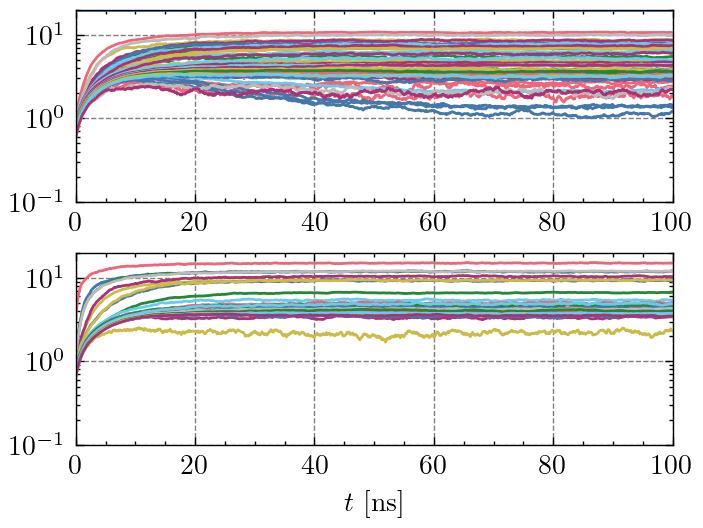

In [157]:
n = 4
type_a_idx = np.where(rad_dis[n]==10.)[0]
type_b_idx = np.where(rad_dis[n]==20.)[0]

fig = plt.figure(dpi=200, layout='constrained')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(t_vals,pot[n].iloc[:,type_a_idx]*1000)
ax2.plot(t_vals, pot[n].iloc[:,type_b_idx]*1000)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
ax1.set_ylim(0.1,20)
ax2.set_ylim(0.1,20)
ax2.set_xlabel("$t$ [ns]")

## Average Potentials

In [78]:
pot_mean = pd.DataFrame(np.mean([pot[i] for i in range(N_nets)],axis=0))
pot_std  = pd.DataFrame(np.std([pot[i] for i in range(N_nets)],axis=0))

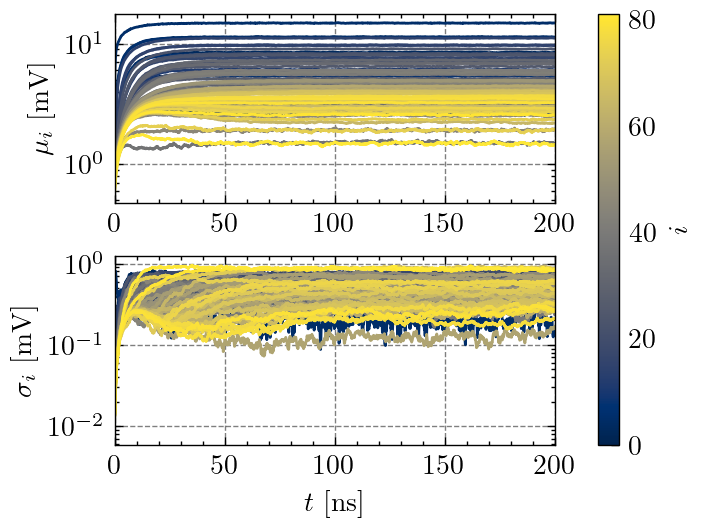

In [79]:
fig     = plt.figure(dpi=200, layout='constrained')
ax1     = fig.add_subplot(2,1,1)
ax2     = fig.add_subplot(2,1,2)
norm    = Normalize(vmin=0, vmax=81)
for i in range(1,N_particles+1):
    ax1.plot(t_vals, pot_mean[i].values*1000, color=cm(norm(i)))
    ax2.plot(t_vals, pot_std[i].values*1000, color=cm(norm(i)))
axes = [ax1,ax2]
ax1.set_xlim(0,200)
ax2.set_xlim(0,200)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylabel("$\mu_{i}$ [mV]")
ax2.set_ylabel("$\sigma_{i}$ [mV]")
ax2.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes)
cbar.set_label("$i$")

In [126]:
p_vals_mean, cov_vals_mean = [], []
p0, p1 = 0.2, 0.95
for k in range(1, N_particles+1):
    x       = t_vals.copy()
    y       = pot_mean.loc[:,k].values
    y_max   = np.mean(y[-5000:])
    def func(t, tau, a0):
        return y_max - a0*np.exp(-t/tau)
    
    t0      = np.argmax(y>p0*y_max)
    t1      = np.argmax(y>p1*y_max)
    x_fit   = x.copy()[t0:t1]
    y_fit   = y.copy()[t0:t1]
    p, cov  = curve_fit(func, x_fit, y_fit, p0=[10,y_max], bounds=((0,0),(np.inf,np.inf)))

    p_vals_mean.append(p)
    cov_vals_mean.append(cov)
p_vals_mean     = np.array(p_vals_mean)
cov_vals_mean   = np.array(cov_vals_mean)

In [127]:
p_vals_ref, cov_vals_ref = [], []
p0, p1 = 0.2, 0.95
for k in range(1, N_particles+1):
    x       = t_vals.copy()
    y       = pot_ref.loc[:,k].values
    y_max   = np.mean(y[-5000:])
    def func(t, tau, a0):
        return y_max - a0*np.exp(-t/tau)
    
    t0      = np.argmax(y>p0*y_max)
    t1      = np.argmax(y>p1*y_max)
    x_fit   = x.copy()[t0:t1]
    y_fit   = y.copy()[t0:t1]
    p, cov  = curve_fit(func, x_fit, y_fit, p0=[10,y_max], bounds=((0,0),(np.inf,np.inf)))

    p_vals_ref.append(p)
    cov_vals_ref.append(cov)
p_vals_ref     = np.array(p_vals_ref)
cov_vals_ref   = np.array(cov_vals_ref)

/tmp/ipykernel_3165/1938273136.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  p, cov  = curve_fit(func, x_fit, y_fit, p0=[10,y_max], bounds=((0,0),(np.inf,np.inf)))


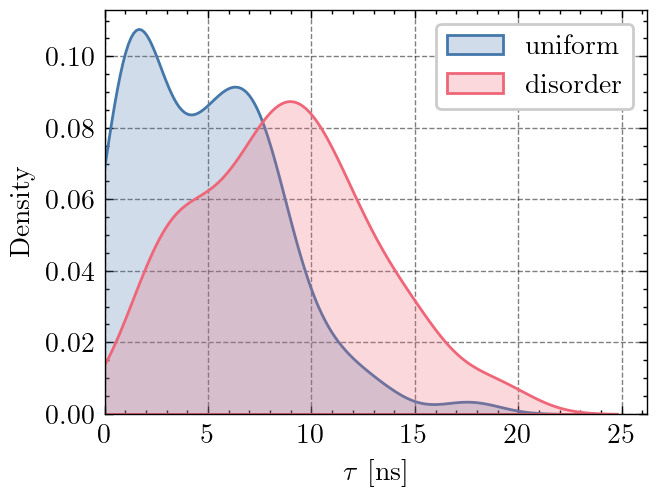

In [125]:
fig, ax = plt.subplots(dpi=200)
ax = sns.kdeplot(p_vals_ref[:,0], ax=ax, fill=True, label='uniform')
ax = sns.kdeplot(p_vals_mean[:,0], ax=ax, fill=True, label='disorder')
ax.set_xlabel("$\\tau$ [ns]")
ax.set_xlim(0)
ax.legend()

## Output Potential

In [128]:
output = {i : pd.read_csv(f"{folder}custom_network_{i}.csv").round(5)['Observable'].values for i in range(N_nets)}

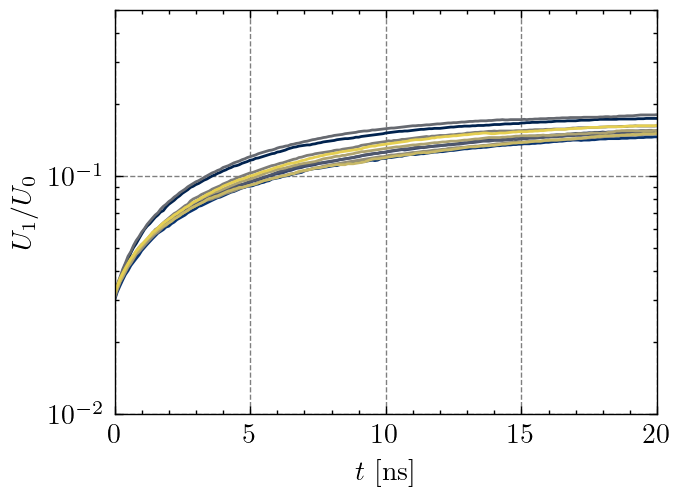

In [129]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=N_nets)
for i in range(N_nets):
    ax.plot(t_vals, output[i]/U_0, color=cm(norm(i)))
ax.set_ylabel("$U_1/U_0$")
ax.set_xlabel("$t$ [ns]")
ax.set_xlim(0,20)
ax.set_ylim(0.01,0.5)
ax.set_yscale('log')

## Potential Curves

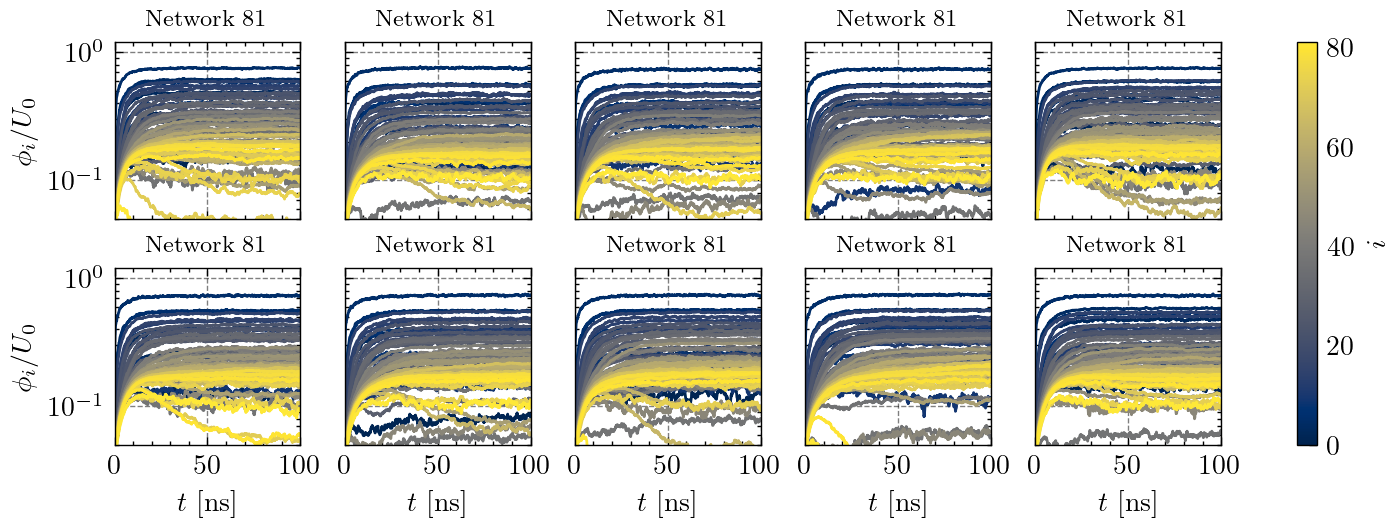

In [5]:
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
norm    = Normalize(vmin=0, vmax=81)
all_ax  = []

for n in range(N_nets):
    ax = fig.add_subplot(2,5,n+1)
    all_ax.append(ax)
    for i in range(1,N_particles+1):
        ax.plot(t_vals, pot[n][i].values/U_0, color=cm(norm(i)))
    ax.set_title(f"Network ${i}$", fontsize='small')
    ax.set_xlim(0,100)
    ax.set_ylim(0.05,1.2)
    ax.set_yscale('log')
    
    if n % 5 == 0:
        ax.set_ylabel("$\phi_i / U_0$")
    else:
        ax.set_yticklabels("")
    if n >= 5:
        ax.set_xlabel("$t$ [ns]")
    else:
        ax.set_xticklabels("")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=all_ax)
cbar.set_label("$i$")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

## Potential Correlation

ValueError: cannot reshape array of size 82 into shape (9,newaxis)

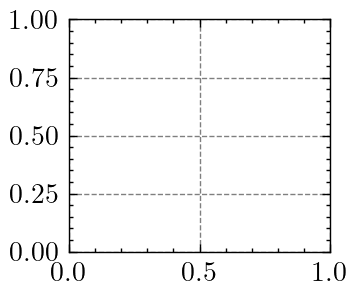

In [20]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
all_ax  = []
norm    = Normalize(vmin=0, vmax=1)
for n in range(N_nets):
    ax  = fig.add_subplot(2,5,n+1)
    arr = pot[n].drop(columns=[0,82]).corr().iloc[:,N_particles//2].values.reshape(N_p,-1)
    ax = sns.heatmap(arr, cmap='Reds', vmin=0, vmax=1, cbar=False)
    _  = plt.yticks(rotation=0)
    ax.invert_yaxis()
    all_ax.append(ax)
    if n % 5 == 0:
        ax.set_ylabel("$j$")
    else:
        ax.set_yticklabels("")
    if n >= 5:
        ax.set_xlabel("$i$")
    else:
        ax.set_xticklabels("")

ax.set_title(f"$U_0 = {U_0}$ V", fontsize='small')

sm  = ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=all_ax)
cbar.set_label("$<\phi_{4,4}\phi_{i,j}>$")

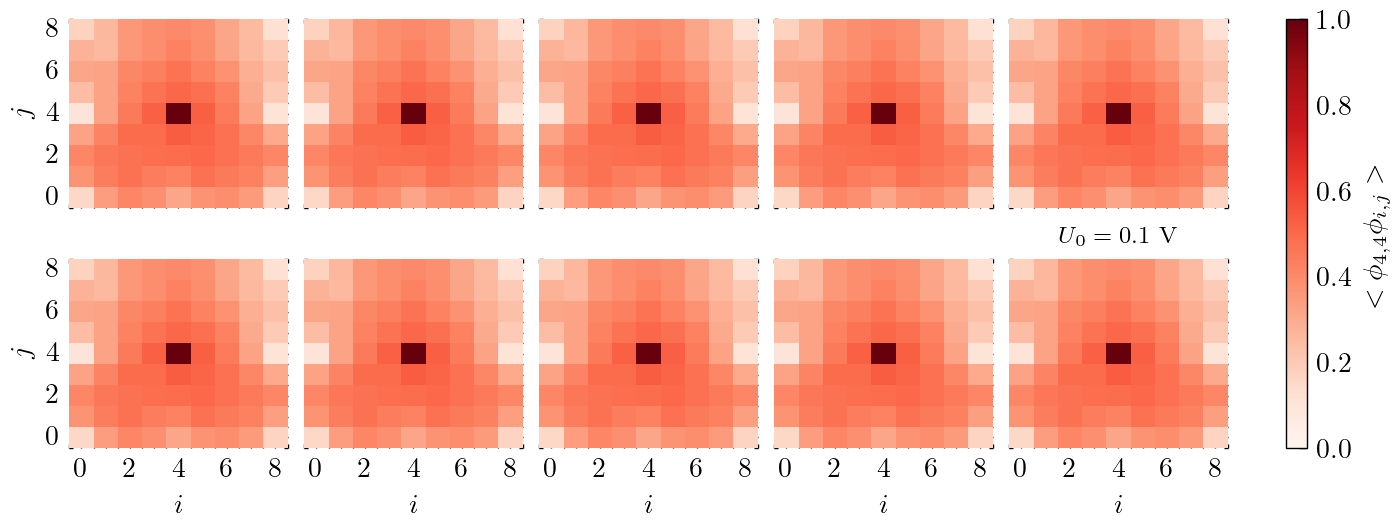

In [46]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
all_ax  = []
norm    = Normalize(vmin=0, vmax=1)
for n, U_0 in enumerate(U0_vals):
    ax  = fig.add_subplot(2,5,n+1)
    arr = pot_8[0.01].drop(columns=[0,82]).corr().iloc[:,N_particles//2].values.reshape(N_p,-1)
    ax = sns.heatmap(arr, cmap='Reds', vmin=0, vmax=1, cbar=False)
    _  = plt.yticks(rotation=0)
    ax.invert_yaxis()
    all_ax.append(ax)
    if n % 5 == 0:
        ax.set_ylabel("$j$")
    else:
        ax.set_yticklabels("")
    if n >= 5:
        ax.set_xlabel("$i$")
    else:
        ax.set_xticklabels("")

ax.set_title(f"$U_0 = {U_0}$ V", fontsize='small')

sm  = ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=all_ax)
cbar.set_label("$<\phi_{4,4}\phi_{i,j}>$")

## Characteristic Time Scale @ Potentials

In [138]:
p_vals_2, cov_vals_2 = {}, {}
p0, p1 = 0.2, 0.9
for U_0 in U0_vals:
    p_tmp, cov_tmp = [], []
    for k in range(1, N_particles+1):

        x       = t_vals.copy()
        y       = pot_2[U_0].loc[:,k].values
        y_max   = np.mean(y[-5000:])
        def func(t, tau, a0):
            return y_max - a0*np.exp(-t/tau)
        
        t0      = np.argmax(y>p0*y_max)
        t1      = np.argmax(y>p1*y_max)
        x_fit   = x.copy()[t0:t1]
        y_fit   = y.copy()[t0:t1]
        p, cov  = curve_fit(func, x_fit, y_fit, p0=[50,y_max], bounds=((0,0),(np.inf,np.inf)))

        p_tmp.append(p)
        cov_tmp.append(cov)
    p_vals_2[U_0] = np.array(p_tmp)
    cov_vals_2[U_0] = np.array(cov_tmp)

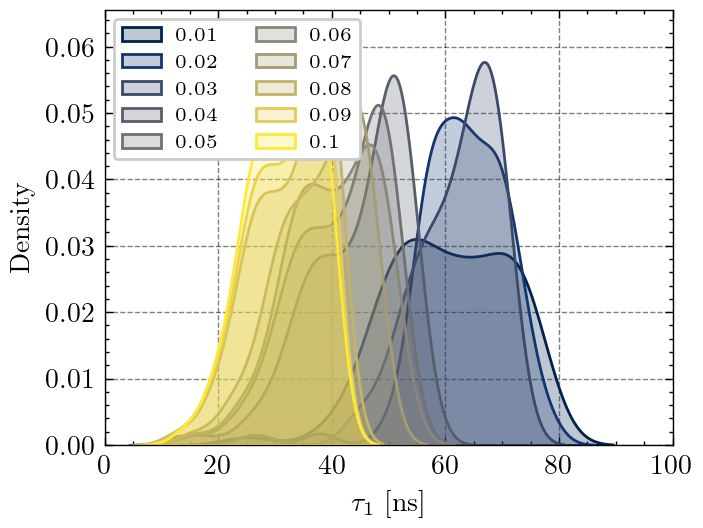

In [139]:
fig = plt.figure(dpi=200, layout='constrained')
norm = Normalize(vmin=U0_vals[0], vmax=U0_vals[-1])
ax  = fig.add_subplot()

for U_0 in U0_vals:
    arr = p_vals_2[U_0][:,0].copy()
    ax  = sns.kdeplot(arr, color=cm(norm(U_0)), fill=True, bw_adjust=1, cumulative=False)
    ax.set_xlabel("$\\tau_1$ [ns]")

ax.set_xlim(0,100)
ax.legend(U0_vals, ncol=2, loc='upper left', fontsize='x-small')

In [140]:
p_vals_8, cov_vals_8 = {}, {}
p0, p1 = 0.2, 0.9
for U_0 in U0_vals:
    p_tmp, cov_tmp = [], []
    for k in range(1, N_particles+1):

        x       = t_vals.copy()
        y       = pot_8[U_0].loc[:,k].values
        y_max   = np.mean(y[-5000:])
        def func(t, tau, a0):
            return y_max - a0*np.exp(-t/tau)
        
        t0      = np.argmax(y>p0*y_max)
        t1      = np.argmax(y>p1*y_max)
        x_fit   = x.copy()[t0:t1]
        y_fit   = y.copy()[t0:t1]
        try:
            p, cov  = curve_fit(func, x_fit, y_fit, p0=[5,y_max], bounds=((0,0),(np.inf,np.inf)))
        except:
            p   = np.array([np.nan,np.nan])
            cov = np.array([[np.nan,np.nan],[np.nan,np.nan]])
        p_tmp.append(p)
        cov_tmp.append(cov)
    p_vals_8[U_0] = np.array(p_tmp)
    cov_vals_8[U_0] = np.array(cov_tmp)

/tmp/ipykernel_13123/3194368290.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  p, cov  = curve_fit(func, x_fit, y_fit, p0=[5,y_max], bounds=((0,0),(np.inf,np.inf)))


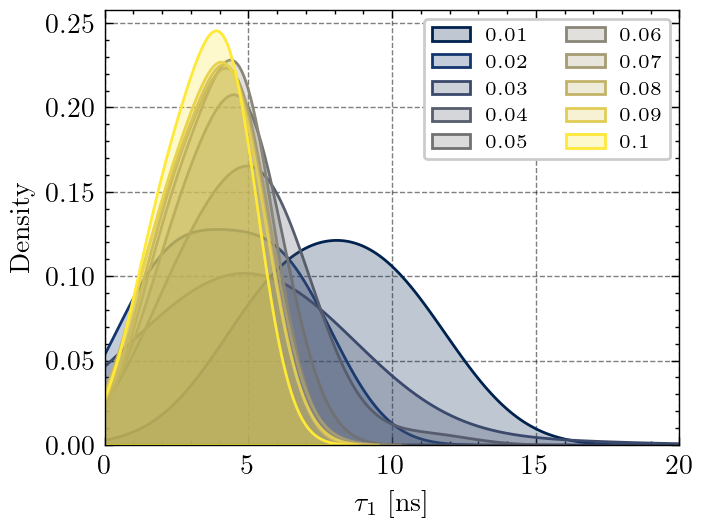

In [141]:
fig = plt.figure(dpi=200, layout='constrained')
norm = Normalize(vmin=U0_vals[0], vmax=U0_vals[-1])
ax  = fig.add_subplot()

for U_0 in U0_vals:
    arr = p_vals_8[U_0][:,0].copy()
    ax  = sns.kdeplot(arr, color=cm(norm(U_0)), fill=True, bw_adjust=2, cumulative=False)
    ax.set_xlabel("$\\tau_1$ [ns]")

ax.set_xlim(0,20)
ax.legend(U0_vals, ncol=2, loc='upper right', fontsize='x-small')

## Characteristic Time Scale @ Output

In [143]:
p_vals_2, cov_vals_2 = [], []
p0, p1 = 0.2, 0.9
for U_0 in U0_vals:

    x       = t_vals.copy()
    y       = output_2[U_0]
    y_max   = np.mean(y[-5000:])
    def func(t, tau, a0):
        return y_max - a0*np.exp(-t/tau)
    
    t0      = np.argmax(y>p0*y_max)
    t1      = np.argmax(y>p1*y_max)
    x_fit   = x.copy()[t0:t1]
    y_fit   = y.copy()[t0:t1]
    p, cov  = curve_fit(func, x_fit, y_fit, p0=[5,y_max], bounds=((0,0),(np.inf,np.inf)))

    p_vals_2.append(p)
    cov_vals_2.append(cov)
p_vals_2 = np.array(p_vals_2)
cov_vals_2 = np.array(cov_vals_2)

Text(0, 0.5, '$\\tau_1$ [ns]')

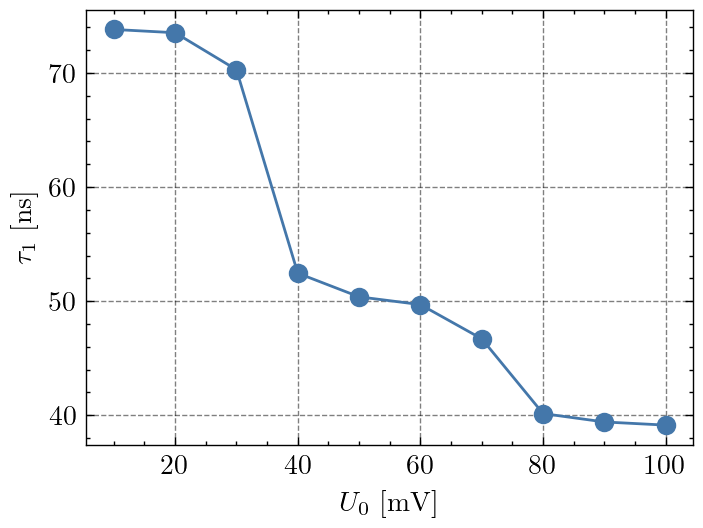

In [144]:
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax.plot(np.array(U0_vals)*1000, p_vals_2[:,0], 'o-')
ax.set_xlabel("$U_0$ [mV]")
ax.set_ylabel("$\\tau_1$ [ns]")

In [145]:
p_vals_8, cov_vals_8 = [], []
p0, p1 = 0.2, 0.9
for U_0 in U0_vals:

    x       = t_vals.copy()
    y       = output_8[U_0]
    y_max   = np.mean(y[-5000:])
    def func(t, tau, a0):
        return y_max - a0*np.exp(-t/tau)
    
    t0      = np.argmax(y>p0*y_max)
    t1      = np.argmax(y>p1*y_max)
    x_fit   = x.copy()[t0:t1]
    y_fit   = y.copy()[t0:t1]
    p, cov  = curve_fit(func, x_fit, y_fit, p0=[5,y_max], bounds=((0,0),(np.inf,np.inf)))

    p_vals_8.append(p)
    cov_vals_8.append(cov)
p_vals_8 = np.array(p_vals_8)
cov_vals_8 = np.array(cov_vals_8)

Text(0, 0.5, '$\\tau_1$ [ns]')

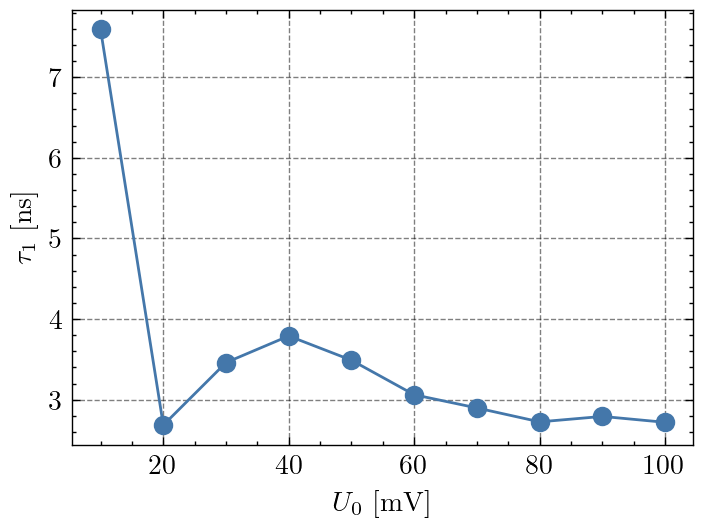

In [146]:
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax.plot(np.array(U0_vals)*1000, p_vals_8[:,0], 'o-')
ax.set_xlabel("$U_0$ [mV]")
ax.set_ylabel("$\\tau_1$ [ns]")